In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline
import baltic as bt
import numpy as np
import pickle
from copy import deepcopy
import dendropy
from collections import defaultdict

In [3]:
out_path = './png/'
colors = pickle.load(open('./colors.p', 'r'))

## Pull trait data from various annotated tree versions
uncollapsed_antigenic_tree = bt.loadJSON('../data/augur-output/dengue_allBranchEffects_tree.json', json_translation={'name': 'clade', 'height': 'cTiter'})
genotype_tree = bt.loadNexus('../frequencies/source/annotated_tree.nexus', absoluteTime=False)

clade_traits = defaultdict(dict)
for k in uncollapsed_antigenic_tree.Objects:
    if 'clade' in k.traits:
        transfer_traits = ['cTiter', 'dTiter', 'clade']
        clade_traits[k.traits['clade']].update({ trait: k.traits[trait] 
                                                for trait in transfer_traits 
                                                if trait in k.traits})
    
for k in genotype_tree.Objects:
    if 'clade' in k.traits:
        transfer_traits = ['genotype', 'serotype']
        clade_traits[k.traits['clade']].update({ trait: k.traits[trait] 
                                                for trait in transfer_traits
                                               if trait in k.traits})
        


Tree height: 1.955144
Tree length: 6.071398
annotations present

Numbers of objects in tree: 4792 (2230 nodes and 2562 leaves)



In [5]:
## Deal with collapsing antigenically uniform clades in dendropy 
## (initially load in baltic to convert from JSON to newick)
antigenic_tree_str = uncollapsed_antigenic_tree.toString()
antigenic_tree_newick_file = './antigenic_tree.newick'
# open(antigenic_tree_newick_file, 'w').write(antigenic_tree_str)

## Now edit to remove the outermost 0.00 bl root to make dendropy happy

In [7]:
# import newick to dendropy tree
dendropy_antigenic_tree = dendropy.Tree.get(file=open(antigenic_tree_newick_file, 'r'), schema='newick')

# collapse internal nodes
for edge in dendropy_antigenic_tree.postorder_edge_iter():
    if edge.tail_node is not None and edge.is_internal():
        if edge.length < 0.01:
            edge.collapse()
            
# prune tips with 0 length branches
# however, need to keep 1 tip per polytomy to properly draw
for node in dendropy_antigenic_tree.postorder_node_iter():
    if node.is_leaf() and node.edge_length < 0.01:
        siblings = node.sibling_nodes()
        no_length_leaf_siblings_count = 0
        for sibling in node.sibling_nodes():
            if sibling.is_leaf() and sibling.edge_length < 0.01:
                no_length_leaf_siblings_count += 1
        if no_length_leaf_siblings_count > 0:
            dendropy_antigenic_tree.prune_subtree(node)

collapsed_antigenic_tree_file = './collapsed_antigenic_tree.newick'
dendropy_antigenic_tree.write(path=collapsed_antigenic_tree_file, schema='newick')

In [5]:
## load the collapsed tree into baltic and attach traits
collapsed_antigenic_tree_file = './collapsed_antigenic_tree.newick'
collapsed_antigenic_tree_str = open(collapsed_antigenic_tree_file, 'r').readlines()[0].strip()
collapsed_antigenic_tree = bt.tree()
bt.make_tree(collapsed_antigenic_tree_str, collapsed_antigenic_tree)
collapsed_antigenic_tree.traverse_tree()
collapsed_antigenic_tree.sortBranches()
collapsed_antigenic_tree.drawTree()

## load the collapsed tree into baltic and attach traits
collapsed_antigenic_tree_str = open(collapsed_antigenic_tree_file, 'r').readlines()[0].strip()
collapsed_antigenic_tree = bt.tree()
bt.make_tree(collapsed_antigenic_tree_str, collapsed_antigenic_tree)
collapsed_antigenic_tree.traverse_tree()
collapsed_antigenic_tree.sortBranches()
collapsed_antigenic_tree.drawTree()

## Recover the metadata we stored earlier
for k in collapsed_antigenic_tree.Objects:
    if hasattr(k, 'numName'):
        clade = int(k.numName)
        if clade in clade_traits:
            k.traits = clade_traits[clade]
            k.name = clade

In [26]:
def get_width(k, tree, trait):
    same_trait_val = [w for w in tree.Objects if w.branchType=='leaf' and w.traits[trait] == k.traits[trait]]
    return len(same_trait_val)

for k in collapsed_antigenic_tree.Objects:
    if 'clade' in k.traits:
        uncollapsed_k = [w for w in uncollapsed_antigenic_tree.Objects if w.traits['clade'] == k.traits['clade']][0]
        k.traits['width'] = get_width(uncollapsed_k, uncollapsed_antigenic_tree, 'cTiter')
    k.width = 1

In [81]:
def plot_tree(ll, ax):
    sns.set(style='white')

    max_width = max([k.traits['width'] for k in ll.Objects if 'width' in k.traits])
    branchWidth = 3

    for k in ll.Objects: # Plot objects
        x=k.x 
        y=k.y 

        xp=k.parent.x 
        yp=k.parent.y
        if x==None:
            x=0.0
        if xp==None:
            xp=x

        ## Color
        if 'genotype' in k.traits and 'SYLVATIC' not in k.traits['genotype']:
            genotype = k.traits['genotype']
            c = colors[genotype]
            label = genotype.replace('_', ' ')
        elif 'serotype' in k.traits:
            serotype = k.traits['serotype']
            c = colors[k.traits['serotype']]
            label = serotype
        else:
            c = 'darkgray'
            label = 'interserotype'

        z=10
        s = 200
        if 'width' in k.traits:
            s = s*k.traits['width']/max_width

        if label != 'interserotype':
            ax.scatter(x,y,s=s+10,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            ax.scatter(x,y,s=(s+10)*2,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
            if label.startswith('DENV1'):
                ax.text(x-0.1, y, label, ha='right', va='center')
            else:
                ax.text(x+0.1, y, label, ha='left', va='center')

        ax.plot([xp,x],[yp,y],lw=branchWidth,color=c,ls='-',zorder=9)

    ax.plot([0,.5], [-2,-2], lw=branchWidth, color='darkgray', ls='-')
    ax.text(0.25,-1.9, '1-fold titer drop', va='bottom', ha='center')
    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.tick_params(axis='x',size=0) ## no labels
    ax.tick_params(axis='y',size=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

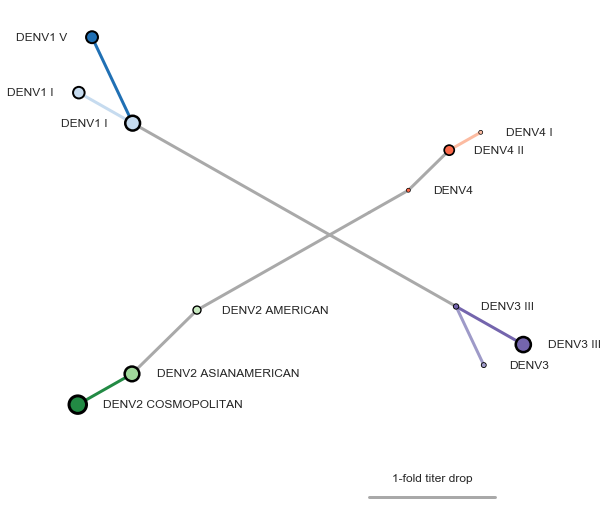

In [83]:
collapsed_antigenic_tree.drawUnrooted()
sns.set(style='white', font_scale=1.2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7.5, 7.5)) # quarter page

plot_tree(collapsed_antigenic_tree, ax=ax)#, cmap=cmap)

plt.tight_layout()
plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
plt.show()

In [38]:
# import matplotlib as mpl
# import matplotlib.gridspec as gridspec

# def plot_radial_tree(tree, ax, cax, cmap=colors['cmap']):
    
#     ## Color bar and formatting
#     sns.set(style='white', font_scale=1.2)
# #     max_c = max([k.traits[colorby] for k in tree.Objects if colorby in k.traits ])
    
# #     norm = mpl.colors.Normalize(vmin=0, vmax=max_c)
# #     cb = mpl.colorbar.ColorbarBase(ax=cax, cmap=cmap, orientation='vertical', 
# #                                    norm=norm, label="Cumulative log2(titer) distance from root")    
# #     cax.yaxis.set_label_position('left')
# #     cax.yaxis.set_ticks_position('left')
# #     cb.set_label("Cumulative log2(titer) distance from root", )

#     ## Setup params
#     branchWidth=3 
#     inwardSpace=-1.15 # < -1 points outwards; > 1 points inwards
#     gap=0.6 # determines how much of their allocated space along the circle a tree uses
#     startFrom=np.pi ## start at some point along the circle

#     ## Bounds
#     leaves = [k for k in tree.Objects if k.branchType=='leaf']
#     leafCount = len(leaves)
#     mostRecent = max([float(k.traits['cTiter']) for k in leaves])
#     max_width = max([k.traits['width'] for k in tree.Objects if isinstance(k, bt.clade)])

#     ## Plot Objects
#     for k in tree.Objects: 
#         ### Coordinates
#         y=k.y 
#         x=k.x 
#         xp=k.parent.x 

#         if x==None: 
#             x=0.0
#         if xp==None:
#             xp=x

#         ### Convert to polar
#         xc=inwardSpace+((mostRecent-x)/tree.treeHeight) ## transform x coordinate
#         xpc=inwardSpace+((mostRecent-xp)/tree.treeHeight) ## transform x parent's coordinate
#         yc=2*np.pi*(y/float(leafCount))*gap ## transform y coordinate

#         ### Color
#         clade = k.traits['clade']
#         if clade in genotype_lookup and 'SYLVATIC' not in genotype_lookup[clade]:
#             genotype = genotype_lookup[clade]
#             c = colors[genotype]
#         elif clade in serotype_lookup:
#             serotype = serotype_lookup[clade]
#             c = colors[serotype]
#         else:
#             c = 'darkgray'

#         if k.branchType=='leaf': ### Plot tips and clades
#             if isinstance(k, bt.clade):
#                 s = k.traits['width']
#             else:
#                 s = 20
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s,facecolor=c,edgecolor='none',zorder=50) ## plot circle for every tip
#             ax.scatter(np.sin(yc)*xc,np.cos(yc)*xc,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=40) ## plot black circle underneath

#         elif isinstance(k,bt.node): ### Plot nodes
#             yl=k.children[-1].y 
#             yr=k.children[0].y 
#             ycl=2*np.pi*(yl/float(leafCount))*gap 
#             ycr=2*np.pi*(yr/float(leafCount))*gap 
#             ybar=np.linspace(ycl,ycr,15) ## create a curved bar
#             ax.plot(np.sin(ybar)*xc,np.cos(ybar)*xc,lw=branchWidth,color=c,ls='-',zorder=30) ## plot curved bar at the base of a node

#         ### Plot ancestralbranch
#         ax.plot([np.sin(yc)*xc,np.sin(yc)*xpc],[np.cos(yc)*xc,np.cos(yc)*xpc],lw=branchWidth,color=c,ls='-',zorder=30)

                     
#     ## Final axis formatting
#     ax.spines['top'].set_visible(False) 
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_visible(False)
#     ax.spines['bottom'].set_visible(False)

#     ax.tick_params(axis='x',size=0) 
#     ax.tick_params(axis='y',size=0)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     ax.set_aspect(1) 
#     x0,x1 = plt.xlim()
#     plt.xlim((x0-0.1, x1+0.1))
#     y0,y1 = plt.ylim()
#     plt.ylim((y0-0.2,y1+0.3))

# titer_tree.drawTree()
# sns.set(style='white', font_scale=1.2)
# fig, (cax, ax) = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 7.5), gridspec_kw={'width_ratios': (0.02, 1.)}) # quarter page

# plot_tree(titer_tree, ax=ax, cax=cax)

# circles = [patches.Circle((0,0), radius=n, axes=ax, ec='lightgray', fc='none', ls='--', lw=1) for n in [0.25, 0.75, 1.25]]
# circles += [patches.Circle((0,0), radius=n, axes=ax, ec='darkgray', fc='none', ls='--', lw=1) for n in [0.5, 1.]]

# for circ in circles:
#     ax.add_patch(circ)

# plt.tight_layout()
# # plt.savefig('./png/antigenic_tree.png', dpi=300, bbox_inches='tight')
# plt.show()